<a href="https://colab.research.google.com/github/fdsig/ssim_retrieval/blob/main/image_retrival_ava_benchmark_with_complete_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SSIM IMAGE RETRIEVAL on AVA BENCMARKING DATASET

> the below is a final but non optimized search which strips images form pdfs and cross references them against AVA BENCHMARKING DATASET.

> The intention is that this should be used as a research tool only and for papers realtaing to a dataset where both the paper and the dataset are publicly availble. 

> it is not uncommot for reserch to illustrate metric scores on particular images, howarev the origional image is not always identified with its ID in the database, therfore where attempting to reproduce metrics for particular images is a usfull part of your own reserarch it may be useful retrive these images from the dataset.

##### if you are using this for some datase and some related paper:
>> 1. Put the pdfs in the ssim_retrieval/pdfs_to_scan folder.

>> 2. Change file directory in code to your own image database.

> Else: all else should run.


Disclamer and Liscence:

you may use,addapt, reuse any aspect of this code- at your own risk of cuorse- not that there is anything malicious or neferious in this code,

you should check your avaialbel virtual mmory befor resizing image funciton
is called and before re reading the thumbnail images 

ADJUST batches according to memmory. 

the below will run on an high RAM colab runtime without issue.

Although there will be some spikes in RAM ussage, the code should cleanup after itself. 

>> I would welcome feedback on any aspect of this code and also to hear form any computer vision enthrusiasts.


In [17]:
#!rm -rf ssim_retrieval/

In [3]:
!git clone https://github.com/fdsig/ssim_retrieval.git
!git clone https://github.com/fdsig/image_utils.git
!mv image_utils/image_getter.py ./image_getter.py



Cloning into 'ssim_retrieval'...
remote: Enumerating objects: 737, done.
remote: Counting objects: 100% (737/737), done.
remote: Compressing objects: 100% (727/727), done.
remote: Total 737 (delta 13), reused 731 (delta 9), pack-reused 0
Receiving objects: 100% (737/737), 120.19 MiB | 23.42 MiB/s, done.
Resolving deltas: 100% (13/13), done.
Checking out files: 100% (1230/1230), done.
Cloning into 'image_utils'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 13 (delta 4), reused 11 (delta 2), pack-reused 0
Unpacking objects: 100% (13/13), done.


In [4]:
!pip install -r /content/ssim_retrieval/requirements.txt
!pip install fitz
!pip install frontend
!pip install PyMuPDF


     |████████████████████████████████| 75 kB 2.2 MB/s 
     |████████████████████████████████| 146 kB 43.9 MB/s 
     |████████████████████████████████| 97 kB 4.9 MB/s 
     |████████████████████████████████| 4.5 MB 52.2 MB/s 
ERROR: Could not find a version that satisfies the requirement frontend==0.0.3 (from versions: none)
ERROR: No matching distribution found for frontend==0.0.3
  Using cached fitz-0.0.1.dev2-py2.py3-none-any.whl (20 kB)
  Using cached configobj-5.0.6.tar.gz (33 kB)
  Using cached configparser-5.0.2-py3-none-any.whl (19 kB)
     |████████████████████████████████| 3.2 MB 12.6 MB/s 
     |████████████████████████████████| 78 kB 5.3 MB/s 
     |████████████████████████████████| 5.1 MB 63.1 MB/s 
     |████████████████████████████████| 129 kB 74.4 MB/s 
  Using cached etelemetry-0.2.2-py3-none-any.whl (6.2 kB)
     |████████████████████████████████| 376 kB 72.2 MB/s 
     |████████████████████████████████| 421 kB 47.2 MB/s 
  Using cached ci_info-0.2.0-py3-none-any.wh

In [63]:
import image_getter
from tqdm import tqdm
import fitz
import io
import os
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from psutil import virtual_memory
import numpy as np
import sys
import time
import pkgutil
import shutil
import matplotlib.pyplot as plt
import gc
import zipfile
import pandas as pd


### GETTING IMAGES

> uses a python sricpt from anothoer git hub repository that i wrote to get very large file without mounting your own google drive in google colab- a workaround. 44 zip files of the whole AVA Benchmarking DATASET are 32GB which will take about 15 mins for google collab to retrive. The origionals are shared on Frida de Sigley's google drive as compressed zips. The individual files are about 750 mb- the size of a cd. 

In [9]:
#uncomment below if you need to re run
#!rm -rf Images
get = image_getter.Get_Ava()
get.download_ava_files(own_drive=False, dowload=True, full=True)


Drive not mounted, so nothing to flush and unmount.
{'own_drive': True, 'dowload': True, 'full': True}
Mounted at /content/drive


KeyboardInterrupt: ignored

an issutratio of how images are batch up to n, the last batch unless the batch size is a prime factor will be smaller. I have elswere batch ava into prime factors where uniform batch size is non trival matter- the dowloaded files from abve cell is one such instance. 

In [3]:
test = list(range(97))
[test[i-10:i] for i in range(10,110,10)]

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
 [30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
 [40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
 [50, 51, 52, 53, 54, 55, 56, 57, 58, 59],
 [60, 61, 62, 63, 64, 65, 66, 67, 68, 69],
 [70, 71, 72, 73, 74, 75, 76, 77, 78, 79],
 [80, 81, 82, 83, 84, 85, 86, 87, 88, 89],
 [90, 91, 92, 93, 94, 95, 96]]

###Thumbnail
> genrates 128,128 thumbnails of originals- this will distort(transform) the aspect ratio on almos all images (its rare that image are aready square)  

In [18]:
#ava = [img.path for img in os.scandir('Images/images/')]
#constant = 15000
#batches_gen = (ava[btc-constant:btc] for btc in range(constant,len(ava)+constant,constant))

#img = cv2.imread(ava[0])
def thumbnail(batches_gen):
    for batch in batches_gen:
        if 'btc' in locals() or 'btc' in globals():
            del btc
            gc.collect()
            space = virtual_memory().total/1024**3
            print('RAM Cleared', 'gb free=', space)
        btc = {img_fid:cv2.imread(img_fid) for img_fid in tqdm(batch,position=0, leave=True)}
        for img_key in btc:
            img = cv2.cvtColor(btc[img_key],cv2.COLOR_BGR2GRAY)
            scalar = 2**7
            dim = (scalar, scalar)
            try:
                img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)        
                cv2.imwrite(img_key,img)
            except:
                img = cv2.cvtColor(btc[img_key],cv2.COLOR_BGR2GRAY)
                cv2.imwrite(img_key,img)

#thumbnail(batches_gen)
#drive_dir = '/content/drive/MyDrive/0.AVA/Grey/grey_ava_thumbnail'
#shutil.make_archive(drive_dir, 'zip', 'Images/images')



(128, 128, 3)


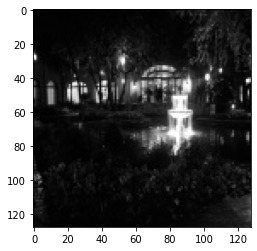

In [12]:

drive_dir = '/content/drive/MyDrive/0.AVA/Grey/grey_ava_thumbnail.zip'
zip_ref = zipfile.ZipFile(drive_dir, 'r')
zip_ref.extractall("./Images/ava_thumb")
zip_ref.close()

ava = [img.path for img in os.scandir('Images/ava_thumb/')]
constant = 15000
batches_gen = (ava[btc-constant:btc] for btc in range(constant,len(ava)+constant,constant))

img = cv2.imread(ava[0])
print(img.shape)
plt.imshow(img)

(128, 128, 3)


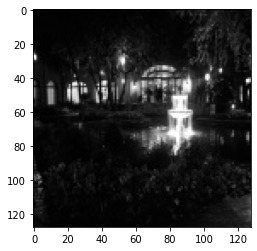

In [13]:
img_t = cv2.resize(img, (128,128), interpolation = cv2.INTER_AREA)   
print(img_t.shape)
plt.imshow(img_t)

An example not used but inclued for interes of further flattening image in a way that might support faster matching


(128, 128)
(128, 128)


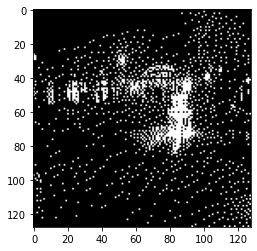

In [14]:
from PIL import Image
I = Image.open(ava[0])
print(I.size)
plt.imshow(I)
L = I.convert('1')
print(L.size)
plt.imshow(L)


In [15]:
fids = [fid.path for fid in os.scandir('ssim_retrieval/ava_specific/') if 'pdf' in fid.name]
len([fid.path for fid in os.scandir('ssim_retrieval/ava_specific/') if 'pdf' in fid.name])

5

In [16]:

for fid in fids:
    pdf = fitz.open(fid)
    name = pdf.name.split('/')[-1]
    print('\n'+name)


Hosu, Goldlucke, Saupe - 2019 - Effective aesthetics prediction with multi-level spatially pooled features-annotated.pdf

Ma, Liu, Wen Chen - 2017 - A-lamp Adaptive layout-aware multi-patch deep convolutional neural network for photo aesthetic assessment-annotated.pdf

Talebi, Milanfar - 2018 - NIMA Neural Image Assessment-annotated.pdf

Sheng et al. - 2018 - Attention-based multi-patch aggregation for image aesthetic assessment-annotated.pdf

aesthetics_cvpr11.pdf


In [27]:

if not os.path.isdir('retrived_images'):
    os.mkdir('retrived_images')
for raw_pdf in fids:
    pdf = fitz.open(raw_pdf)
    name = pdf.name.split('/')[-1]
    for page_id in range(len(pdf)):
        page = pdf[page_id]
        im_lst = page.getImageList()
        if im_lst:
            for id_, img in enumerate(page.getImageList(), start=1):
                    raw = img[0]
                    image = pdf.extractImage(raw)
                    if image!=None:
                        rw_img = pdf.extract_image(raw)
                        img_b = rw_img['image']
                        im_array = np.frombuffer(img_b, np.uint8)
                        img = cv2.imdecode(im_array, -1)
                        cv2.imwrite('retrived_images/'+str(page_id)+name+str(id_)+'.'+rw_img['ext'],img)

                        



In [31]:
doc_im_fids = [fid.path for fid in os.scandir('ssim_retrieval/retrived_images/')]
constant = 20
batches_gen = (doc_im_fids[btc-constant:btc] for btc in range(constant,len(doc_im_fids)+constant,constant))
thumbnail(batches_gen)

print(ims[0])
# this is a duplictae but you would replace this with images
# that you want to cross reference with
ava_fids = [fid.path for fid in os.scandir('Images/ava_thumb/')]


100%|██████████| 20/20 [00:00<00:00, 2354.30it/s]

RAM Cleared gb free= 25.459697723388672



100%|██████████| 20/20 [00:00<00:00, 2804.34it/s]

RAM Cleared gb free= 25.459697723388672



100%|██████████| 20/20 [00:00<00:00, 2821.03it/s]

RAM Cleared gb free= 25.459697723388672



100%|██████████| 20/20 [00:00<00:00, 3334.64it/s]

RAM Cleared gb free= 25.459697723388672



100%|██████████| 12/12 [00:00<00:00, 2718.87it/s]

RAM Cleared gb free= 25.459697723388672
ssim_retrieval/retrived_images/1aesthetics_cvpr11.pdf1.png


In [20]:
gc.collect()
#del ava_batch_dict, doc_batch_dict
gc.collect()

ava_batch_dict = {
    fid:cv2.imread(fid) for fid in 
    tqdm(ava_fids,position=0,leave=True)
    }
doc_batch_dict = {
    fid:cv2.imread(fid) for fid 
    in tqdm(ims,position=0,leave=True)
                                        }

100%|██████████| 112/112 [00:00<00:00, 3228.25it/s]


In [196]:
len(ava_batch_dict)

255508

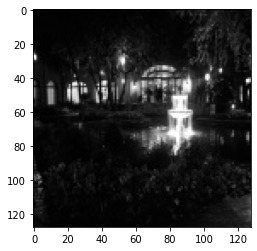

In [21]:
plt.imshow(ava_batch_dict[ava_fids[0]])

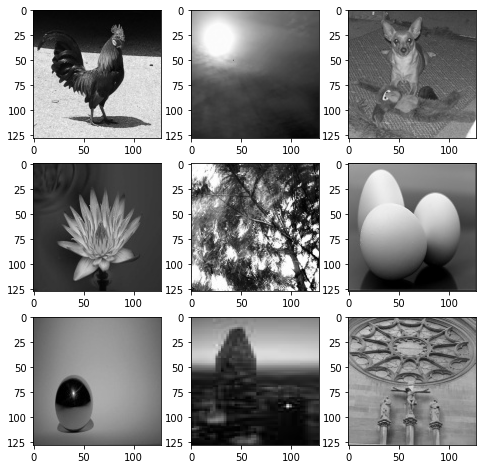

In [160]:
#plots and example of 3,3 ims that have been pulled from pdf documnets
# these are for cross referencing
retrieve_gen = (doc_batch_dict[i] for i in doc_batch_dict)
# shows sample of images that have been thumbnailed
fig, ax = plt.subplots(3,3, figsize=(8,8))
for i in range(3):
    for j in range(3):
        ax[i,j].imshow(next(retrieve_gen))

#### The below cell contians a simple algorythm for matching images using  Structural Similarity Index (SSIM). 

SSIM is outlined by Z. Wang et. al[1] is a computaiton of the multiplicative index of three terms- luminance, contrast, structural:

$$SSIM(x,y) = [l(x,y]^\alpha \cdot [c(x,y)]^\beta \cdot [s(x,y)]^\gamma  $$

where: 

$$l(x,y) = \frac{2\mu_x\mu_y + C_1}{\mu^2_x + \mu^2_y + C_2} $$
$$c(x,y) = \frac{2\sigma_x\sigma_y + C_2}{\sigma^2_x + \sigma^2_y + C_2} $$
$$s(x,y) = \frac{2\sigma_{xy} + C_3}{\sigma_x + \sigma_y + C_3} $$

$\mu_x \mu_y$ are local means
$\sigma_x \sigma_y $ is the local standard deviation
$\sigma_xy$ cross-co varince 

therefore:

$$SSIM(x,y) = \frac{(2\mu_x\mu_y +C_1)(2\sigma_{xy} + C_2)}{(\mu^2_x + \mu^2_y + C_1)(\sigma^2_x + \sigma^2_y + C_2)}$$

ssim of 1 is an exact match to the image



[1]Wang, Z., Bovik, A. C., Sheikh, H. R., & Simoncelli, E. P. (2004). Image quality assessment: From error visibility to structural similarity. IEEE Transactions on Image Processing, 13(4), 600–612. https://doi.org/10.1109/TIP.2003.819861


In [91]:


def matcher(image, batch,fids):
    # created and empty numpy array
    vec = np.zeros(len(batch))
    # if opne CV read returns None Type 
    # then renturns zero value array 
    # a fail safe as some of the iamages pulled
    # (scraped) from pdf's may not be readable
    if image is None:
        return vec
    else:
        #converts to greyscale
        img_a = image
        for img_key, idx in zip(fids,range(len(fids))):
            img_b = batch[img_key]
            if img_b is None:
                # not all id'd images in documents are 
                # readable therfore set 0 where this is the case
                vec[idx]=0
            elif (img_b.shape) == (img_a.shape):
                    vec[idx]=ssim(img_b,img_a,multichannel=True)
            else:
                vec[idx]=0

        # returns a 1D array of ssim score of all images        
    return vec

Becasue the resized 128*128 images are being read into virtual memory good to check what is availbel now- if you exceed this (colab- or your machine) will likely crash.

In [92]:
# rending images into virtual memory 
# will speed up above code and this may effect what batch size that you use
# therfor including GB of free RAM
mem = virtual_memory()
free = mem.free/1024**3
total = mem.total/1024**3
print(f'Avalable RAM G.bytes = {free:.2f} , Total RAM G. Bytes = {total:.2f}')

Avalable RAM G.bytes = 3.92 , Total RAM G. Bytes = 25.46


In [93]:
batch_size = sys.getsizeof(ava_batch_dict.items())/1024**3
print(f'Batch M. Bytes= {batch_size:.8f}')

Batch M. Bytes= 0.00000005


Creates pickle files in a file sepcified loacitno if you are running a whole batch- batches in items of ten- Be warned though- i image takes 15/20 mins
therefor 100 would take more that 24 hours- there is no opetimizaiton of search, as in for example, return match if ssim greater than some threshold which would be an obvious optimizaiton of this and or making use of random sampling- below used pure computational bruit forse to returnn ssim values for all (in this case 250000) images, that is 250000*112 ssim computations (about 30 million). vecotors of ssim scores are innitial stored withing python dictionary and then saved as pkl file for retrival. 

In [ ]:
t_zero = time.time()

# reads a bacth of images at once
# can be optimized according to ram capaciyt
constant = 10
for idx in range(constant,len(doc_im_fids),constant):

    matches = {img_key
            :matcher(doc_batch_dict[img_key]
                        ,ava_batch_dict, ava_fids) 
            for img_key in tqdm(doc_im_fids[idx-constant:idx], total=len(doc_im_fids)
            ,position=1, leave=True)}            
    fid_new = '/content/drive/MyDrive/0.AVA/Grey/matches.pkl'+str(idx)
    with open(fid_new,'wb') as fid:
        pickle.dump(matches, fid)

delta_t = time.time()-t_zero

print(f' time seconds to compare batch {delta_t:.2f}')



  9%|▉         | 10/112 [2:39:39<26:52:03, 948.27s/it]




  9%|▉         | 10/112 [2:39:39<27:08:32, 957.97s/it]

  9%|▉         | 10/112 [2:36:20<26:26:45, 933.39s/it]

  9%|▉         | 10/112 [2:36:20<26:34:42, 938.07s/it]

  9%|▉         | 10/112 [2:33:37<26:07:02, 921.79s/it]

  9%|▉         | 10/112 [2:32:52<25:59:23, 917.29s/it]

  9%|▉         | 10/112 [2:34:28<26:15:33, 926.80s/it]

  9%|▉         | 10/112 [2:35:36<26:27:09, 933.62s/it]

  3%|▎         | 3/112 [45:46<27:44:23, 916.18s/it]

In [87]:
import pickle
#matches = {'s4':np.array([i for i in range(1000)]),'s3':np.array([2,2]),'ss':np.array([1,1])}
fid_new = '/content/drive/MyDrive/0.AVA/Grey/matches.pkl'
with open(fid_new,'wb') as fid:
    pickle.dump(matches, fid)


In [86]:
a_file = open(fid_new, "rb")

output = pickle.load(a_file)

len(output['ssim_retrieval/retrived_images/1aesthetics_cvpr11.pdf1.png'])

255508

In [ ]:
match_matrix = np.vstack([matches[match_array] for match_array in matches])
ssim = match_matrix.ravel()[np.argmax(match_matrix.ravel())]
ssim

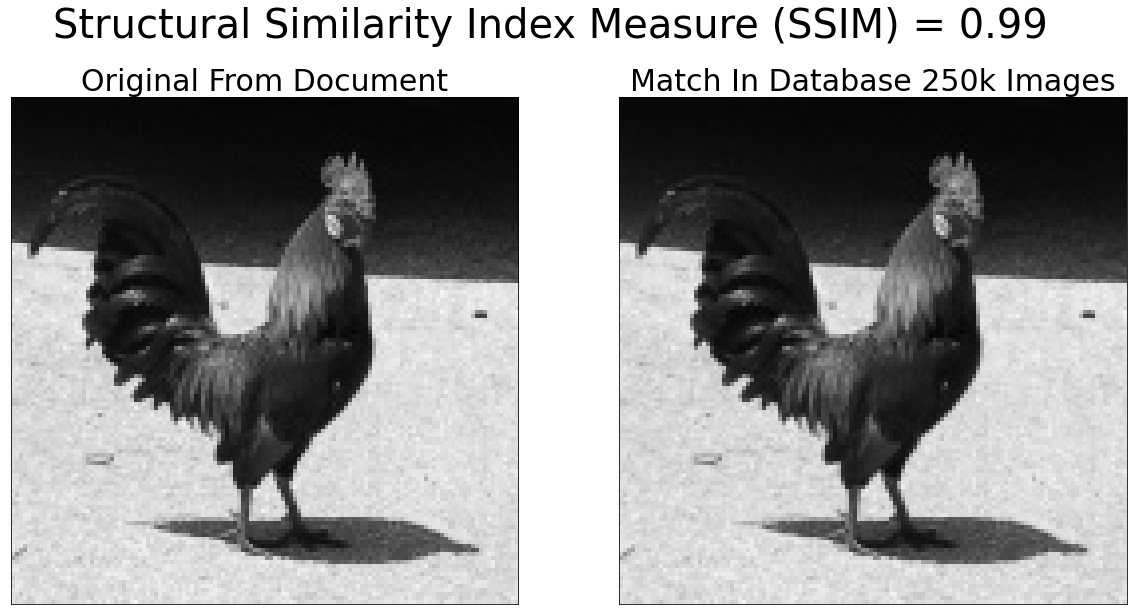

In [125]:
img__ = cv2.imread(list(matches.keys())[np.argmax(match_matrix.ravel())])
show = [img__,batch[:1][0]]
titles = ['Original From PDF Publication', 'Match In Database 250k Images']
fig, ax = plt.subplots(1,2,figsize=(20,10))
fig.suptitle(f'Structural Similarity Index Measure (SSIM) = {ssim:.2f}',size=40)
for i in range(2):
    ax[i].imshow(show[i])
    ax[i].set_yticks([])
    ax[i].set_xticks([])
    ax[i].set_title(titles[i], size=30)


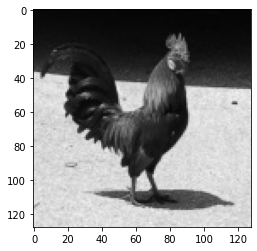

In [79]:
plt.imshow(batch[:1][0])

## Bibleography

Liu, Z., Wang, J., Gong, S., Tao, D., & Lu, H. (2019). Deep reinforcement active learning for human-in-the-loop person re-identification. Proceedings of the IEEE International Conference on Computer Vision, 2019-October, 6121–6130. https://doi.org/10.1109/ICCV.2019.00622

Sun, P., Zhang, W., Wang, H., Li, S., & Li, X. (2021). Deep RGB-D Saliency Detection with Depth-Sensitive Attention and Automatic Multi-Modal Fusion. 1407–1417. http://arxiv.org/abs/2103.11832

Su, H., Niu, J., Liu, X., Li, Q., Wan, J., Xu, M., & Ren, T. (2020). An End-to-end Method for Producing Scanning-robust Stylized QR Codes. http://arxiv.org/abs/2011.07815


Cheng, J., Jaiswal, A., Wu, Y., Natarajan, P., & Natarajan, P. (2021). Style-Aware Normalized Loss for Improving Arbitrary Style Transfer. 134–143. http://arxiv.org/abs/2104.10064

Hosu, V., Goldlucke, B., & Saupe, Di. (2019). Effective aesthetics prediction with multi-level spatially pooled features. Proceedings of the IEEE Computer Society Conference on Computer Vision and Pattern Recognition, 2019-June, 9367–9375. https://doi.org/10.1109/CVPR.2019.00960

Ke, Y., Tang, X., Jing, F., Datta, R., Joshi, D., Li, J., Wang, J. Z., Luo, Y., Tang, X., Cerosaletti, C. D., Loui, A. C., You, J., Perkis, A., Hannuksela, M. M., Gabbouj, M., Li, C., Gallagher, A., Loui, A. C., Chen, T., … Ullah, H. (2021). A Survey of Hand Crafted and Deep Learning Methods for Image Aesthetic Assessment. Lecture Notes in Computer Science (Including Subseries Lecture Notes in Artificial Intelligence and Lecture Notes in Bioinformatics), 21(7), 1–17. https://doi.org/10.1109/EUVIP47703.2019.8946180

Zhang, J., Sclaroff, S., Lin, Z., Shen, X., Price, B., & Mech, R. (2016). Unconstrained salient object detection via proposal subset optimization. Proceedings of the IEEE Computer Society Conference on Computer Vision and Pattern Recognition, 2016-Decem, 5733–5742. https://doi.org/10.1109/CVPR.2016.618


## This Repository contains a pdf image scraping tool in jupyter notebooks and  a simple algorithm for matching/retrival images using Structural Similarity Index (SSIM) on images pulled from pdf. 

SSIM is outlined by Z. Wang et. al[1] is a computation of the multiplicative index of three terms- luminance, contrast, structural:


![txt](eg_ims/ssim1.png)


Where: 


![txt](eg_ims/ssim2.png)


Where 𝜇_𝑥 𝜇_𝑦  are local means 𝜎_𝑥 𝜎_𝑦 is the local standard deviation 𝜎_𝑥 𝑦 cross-covariance.
Therefore:


![txt](eg_ims/ssim3.png)


Fig. 1[2]

![txt](eg_ims/QR.png)


ssim of 1 is an exact match to the image


[1]Wang, Z., Bovik, A. C., Sheikh, H. R., & Simoncelli, E. P. (2004). Image quality assessment: From error visibility to structural similarity. IEEE Transactions on Image Processing, 13(4), 600–612. https://doi.org/10.1109/TIP.2003.819861

[2] Su, H., Niu, J., Liu, X., Li, Q., Wan, J., Xu, M., & Ren, T. (2020). An End-to-end Method for Producing Scanning-robust Stylized QR Codes. http://arxiv.org/abs/2011.07815

#### Instructions

> `Pip Install requirements` txt in new python 3.9.5 virtual environment

> Place PDF files that you want to pull images form in the pdfs_to_scan folder.

> Place images that you want to match against in images_sample_database.

n.b Running notebook may take some time according to how many images are in your  batch of images to identity or image to identity folder.

I have used images from recent pulblication in the The [Computer Vision Foundation](https://www.thecvf.com/) to illustrate. The images are also really amazing examples of computer vision research. 


#### Papers used:

Liu, Z., Wang, J., Gong, S., Tao, D., & Lu, H. (2019). Deep reinforcement active learning for human-in-the-loop person re-identification. Proceedings of the IEEE International Conference on Computer Vision, 2019-October, 6121–6130. [https://doi.org/10.1109/ICCV.2019.00622](https://doi.org/10.1109/ICCV.2019.00622)

Sun, P., Zhang, W., Wang, H., Li, S., & Li, X. (2021). Deep RGB-D Saliency Detection with Depth-Sensitive Attention and Automatic Multi-Modal Fusion. 1407–1417. [http://arxiv.org/abs/2103.11832](http://arxiv.org/abs/2103.11832)

Su, H., Niu, J., Liu, X., Li, Q., Wan, J., Xu, M., & Ren, T. (2020). An End-to-end Method for Producing Scanning-robust Stylized QR Codes. [http://arxiv.org/abs/2011.07815](http://arxiv.org/abs/2011.07815)

Cheng, J., Jaiswal, A., Wu, Y., Natarajan, P., & Natarajan, P. (2021). Style-Aware Normalized Loss for Improving Arbitrary Style Transfer. 134–143. [http://arxiv.org/abs/2104.10064](http://arxiv.org/abs/2104.10064)

Hosu, V., Goldlucke, B., & Saupe, Di. (2019). Effective aesthetics prediction with multi-level spatially pooled features. Proceedings of the IEEE Computer Society Conference on Computer Vision and Pattern Recognition, 2019-June, 9367–9375. [https://doi.org/10.1109/CVPR.2019.00960](https://doi.org/10.1109/CVPR.2019.00960)

Ke, Y., Tang, X., Jing, F., Datta, R., Joshi, D., Li, J., Wang, J. Z., Luo, Y., Tang, X., Cerosaletti, C. D., Loui, A. C., You, J., Perkis, A., Hannuksela, M. M., Gabbouj, M., Li, C., Gallagher, A., Loui, A. C., Chen, T., … Ullah, H. (2021). 

A Survey of Hand Crafted and Deep Learning Methods for Image Aesthetic Assessment. Lecture Notes in Computer Science (Including Subseries Lecture Notes in Artificial Intelligence and Lecture Notes in Bioinformatics), 21(7), 1–17. [https://doi.org/10.110/EUVIP47703.2019.8946180](https://doi.org/10.110/EUVIP47703.2019.8946180)

Zhang, J., Sclaroff, S., Lin, Z., Shen, X., Price, B., & Mech, R. (2016). Unconstrained salient object detection via proposal subset optimization. Proceedings of the IEEE Computer Society Conference on Computer Vision and Pattern Recognition, 2016-Decem, 5733–5742. [https://doi.org/10.1109/CVPR.2016.618](https://doi.org/10.1109/CVPR.2016.618)
